In [1]:
import os
import json
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import seaborn as sns
palette = sns.color_palette("colorblind")

from utils import load_responses, responses_to_acc

In [2]:
responses = load_responses({}, ['llama-3-8b'], 'results/scaling-experiments/')
responses['llama-3-8b-instruct-ft-1e'] = responses.pop('llama-3-8b')  # rename
models = ['llama-3-8b-instruct', 'lawma-8b']
responses = load_responses(responses, ['llama-3-8b-instruct', 'lawma-8b'], 'results/model_responses/')
base_accs = {model: {k: responses_to_acc(v) for k, v in responses[model].items()} for model in responses}

100%|██████████| 260/260 [00:01<00:00, 201.99it/s]


llama-3-8b has 260 tasks


100%|██████████| 260/260 [00:01<00:00, 228.89it/s]


llama-3-8b-instruct has 260 tasks


100%|██████████| 260/260 [00:01<00:00, 210.56it/s]


lawma-8b has 260 tasks


In [3]:
def load_folder_accs(base_dir):
    accs = {}
    for task in tqdm(os.listdir(base_dir)):
        task_files = os.listdir(os.path.join(base_dir, task))

        accs[task] = {}
        for file in task_files:
            with open(os.path.join(base_dir, task, file), 'r') as f:
                responses = json.load(f)
            accs[task] = responses_to_acc(responses)
            
    return accs

base_dir = 'results/specialization/'
outer_dirs = {'warmup': '', 'no-warmup': '+'}
base_models = {'llama-3-8b-instruct': '0e', 
               'llama-3-8b-instruct-ft-1e': '1e',
               'lawma-8b': '3e'}

ft_trials = {}
for outer_dir, outer_dir_suffix in outer_dirs.items():
    for model, model_preffix in base_models.items():
        ft_trials[model_preffix + outer_dir_suffix] = load_folder_accs(base_dir + outer_dir + '/' + model + '/')

100%|██████████| 9/9 [00:00<00:00, 464.81it/s]


In [4]:
task_names = {
        'sc_issuearea': 'SC Issue Area',
        'sc_decisiondirection': 'SC Direction',
        'sc_casedisposition': 'SC Disposition',
        'sc_casesource': 'SC Case Source',
        'sc_lcdisposition': 'SC LC Disposition',
        'songer_geniss': 'Songer Gen. Issue',
        'songer_direct1': 'Songer Direction',
        'songer_treat': 'Songer Treatment',
        'songer_origin': 'Songer Case Origin',
        'sc_lcdispositiondirection': 'SC LC Direction',
}

tasks = task_names.keys()
tasks = sorted(tasks, key=lambda x: base_accs['lawma-8b'][x])


In [5]:
def responses_to_acc_maj(responses, majority_class):
    y_true = [r['ground_truth'] for r in responses]
    y_pred = [r['model_response'] for r in responses]

    if type(majority_class) == int:
        majority_class = ' ' + str(majority_class)

    ids_majority = [i for i, true in enumerate(y_true) if true == majority_class]
    y_true = [y_true[i] for i in ids_majority]
    y_pred = [y_pred[i] for i in ids_majority]

    if len(y_true) == 0:
        print(majority_class, responses)

    is_digit = y_true[0]
    if type(is_digit) == list:
        is_digit = is_digit[0]
    is_digit = is_digit.strip().isdigit()
    if is_digit:
        y_pred = [find_first_integer(pred) for pred in y_pred]
    
    return accuracy(y_true, y_pred), len(y_true)

In [6]:
def take_max(accs, task, key):
    acc1 = accs[key][task]
    if key+'+' in accs and task in accs[key+'+']:
        return max(acc1, accs[key+'+'][task])
    return acc1

In [7]:
accs = {}
for m in ['llama-3-8b-instruct', 'llama-3-8b-instruct-ft-1e', 'lawma-8b']:
    accs[m] = [base_accs[m][task] for task in tasks]
for key in ['0e', '1e', '3e']:
    accs[key] = [take_max(ft_trials, task, key) for task in tasks]

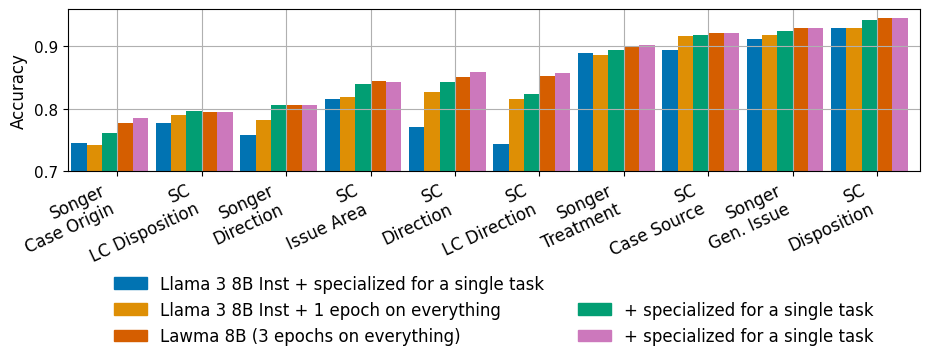

In [8]:
to_plot = ['0e', 'llama-3-8b-instruct-ft-1e', '1e', 'lawma-8b', '3e']
bars_to_plot = [accs[k] for k in to_plot]

fig, ax = plt.subplots(figsize=(11, 2.1))
index = np.arange(len(tasks))

ax.grid()

suffix = '+ specialized for a single task'
labels = [
    'Llama 3 8B Inst ' + suffix,
    'Llama 3 8B Inst + 1 epoch on everything',
    suffix,
    'Lawma 8B (3 epochs on everything)',
    suffix,
]

bar_width = 1. / (len(bars_to_plot)+0.5)
bar_colors = list(palette[:5]) + [palette[6]]
for i in range(len(bars_to_plot)):
    positions = index + i * bar_width - bar_width * 2
    ax.bar(positions, bars_to_plot[i], bar_width, color=bar_colors[i])
              
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_ylim(0.7, 0.96)
ax.set_xlim(-0.5, len(tasks) - 0.4)

ax.tick_params(axis='y', labelsize=11)

ax.set_xticks(index + bar_width / 2)
task_labels = [task_names[task] for task in tasks]
task_labels = [l.split(' ')[0] + '\n' + ' '.join(l.split(' ')[1:]) for l in task_labels]
ax.set_xticklabels(task_labels, rotation=25, ha='right', fontsize=12, va='top')

legend_patches = []
from matplotlib.patches import Patch
for i, label in enumerate(labels):
    legend_patches.append(Patch(color=bar_colors[i], label=label))
legend_patches = [legend_patches[0]] + [Patch(facecolor='none', edgecolor='none', label='')] + legend_patches[1:]

re_order = [0, 2, 4, 1, 3, 5]
legend_patches = [legend_patches[i] for i in re_order]

# place legend below the plot, outside the plot area
ax.legend(handles=legend_patches,loc='upper center', bbox_to_anchor=(0.5, -0.55), ncol=2, frameon=False, fontsize=12)

# save as pdf
plt.savefig('plots/lawma-specialized.pdf', bbox_inches='tight')